In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#import dataframe and drop nans
df_2021 = pd.read_csv('data/2021/2021_combined.csv', dtype={'Data':np.datetime64})

In [3]:
df_2021.describe().round()

,Unnamed: 0,Jaarmaand,Jaar,Maand,Weeknr,v15_1_Scheepstype_RWS,v18_Laadvermogen,v28_Beladingscode,v38_Vervoerd_gewicht,v30_4_Containers_TEU_S,nstr_nw
count,385572.0,385572.0,385572.0,385572.0,385572.0,385572.0,385572.0,385572.0,278134.0,385572.0,274888.0
mean,208710.0,2107.0,2021.0,7.0,27.0,3.0,2446.0,5.0,1243360.0,15.0,6.0
std,120329.0,3.0,0.0,3.0,15.0,5.0,2521.0,3.0,1583801.0,51.0,3.0
min,7.0,2101.0,2021.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
25%,108799.0,2104.0,2021.0,4.0,14.0,1.0,1100.0,1.0,242000.0,0.0,3.0
50%,212580.0,2107.0,2021.0,7.0,26.0,1.0,1820.0,7.0,996000.0,0.0,6.0
75%,312478.0,2110.0,2021.0,10.0,40.0,2.0,3160.0,7.0,1700000.0,0.0,8.0
max,414145.0,2112.0,2021.0,12.0,53.0,36.0,100000.0,7.0,99999000.0,1700.0,9.0


In [4]:
df_2021

,Unnamed: 0,Jaarmaand,Jaar,Maand,Weeknr,Date,v05_06_Begindt_evenement,UNLO_herkomst,UNLO_bestemming,v15_1_Scheepstype_RWS,SK_CODE,v18_Laadvermogen,v28_Beladingscode,v38_Vervoerd_gewicht,v30_4_Containers_TEU_S,nstr_nw,nst2007_nw
0,7,2101,2021,1,53,2021-01-01 00:00:00+00:00,NaN,NLAMS,BEANR,2,M12,8000.0,3,0.0,0,3.0,7.4
1,8,2101,2021,1,53,2021-01-01 00:00:00+00:00,NaN,BEANR,NLTNZ,2,M8,3100.0,3,0.0,0,8.0,8.2
2,9,2101,2021,1,53,2021-01-01 00:00:00+00:00,NaN,NLRTM,DEWOR,4,M8,1160.0,7,604000.0,0,8.0,8.3
3,10,2101,2021,1,53,2021-01-01 00:00:00+00:00,NaN,DESGW,NLRTM,26,BII-6b,17050.0,5,0.0,0,9.0,16
4,11,2101,2021,1,53,2021-01-01 00:00:00+00:00,NaN,BEANR,NLRTM,4,M8,900.0,3,0.0,0,3.0,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385567,414141,2112,2021,12,52,2021-12-31 22:00:00+00:00,31 december 2021 23:00:00 uur,NLRTM,BEGNE,2,M10,3940.0,7,3392000.0,0,3.0,7.2
385568,414142,2112,2021,12,52,2021-12-31 22:00:00+00:00,31 december 2021 23:00:00 uur,DEMHG,BEANR,2,M9,3510.0,3,0.0,0,3.0,7.2
385569,414143,2112,2021,12,52,2021-12-31 22:00:00+00:00,31 december 2021 23:00:00 uur,NLRTM,BEGNE,2,M9,4290.0,7,2000000.0,0,8.0,8.5
385570,414144,2112,2021,12,52,2021-12-31 22:00:00+00:00,31 december 2021 23:00:00 uur,NLRTM,DEDUI,1,M11,5210.0,7,2187044.0,276,9.0,12.1


In [5]:
#remove entries with same origin and destination
df_2021_old = df_2021.copy()
df_2021 = df_2021.loc[df_2021.UNLO_herkomst!=df_2021.UNLO_bestemming]
print(len(df_2021_old)-len(df_2021), "were removed because they had the same origin and dest", len(df_2021),'trips left')

6664 were removed because they had the same origin and dest 378908 trips left


In [6]:
#drop nans
df_2021_old = df_2021.copy()
df_2021 = df_2021.loc[df_2021.SK_CODE.isnull() != True]
x = len(df_2021_old)-len(df_2021)
print(x, "entries were because the SK_CODE entry was missing", (x/len(df_2021_old))*100, "%", len(df_2021), 'trips left')

1614 entries were because the SK_CODE entry was missing 0.42596091927328006 % 377294 trips left


In [7]:
df_2021.describe().round()

,Unnamed: 0,Jaarmaand,Jaar,Maand,Weeknr,v15_1_Scheepstype_RWS,v18_Laadvermogen,v28_Beladingscode,v38_Vervoerd_gewicht,v30_4_Containers_TEU_S,nstr_nw
count,377294.0,377294.0,377294.0,377294.0,377294.0,377294.0,377294.0,377294.0,274222.0,377294.0,271014.0
mean,209019.0,2107.0,2021.0,7.0,27.0,3.0,2448.0,5.0,1242641.0,15.0,6.0
std,120335.0,3.0,0.0,3.0,15.0,5.0,2468.0,3.0,1570668.0,51.0,3.0
min,7.0,2101.0,2021.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
25%,109316.0,2104.0,2021.0,4.0,14.0,1.0,1110.0,1.0,250000.0,0.0,3.0
50%,213004.0,2107.0,2021.0,7.0,26.0,1.0,1830.0,7.0,998000.0,0.0,6.0
75%,312805.0,2110.0,2021.0,10.0,40.0,2.0,3160.0,7.0,1700000.0,0.0,8.0
max,414145.0,2112.0,2021.0,12.0,53.0,34.0,100000.0,7.0,95000000.0,1700.0,9.0


In [8]:
#drop all vessels of type M0 because they are small and engine power varies to much
df_2021_old = df_2021.copy()
df_2021 = df_2021.loc[df_2021.SK_CODE != 'M0']
x = len(df_2021_old)-len(df_2021)
print(x, "entries were because the SK_CODE was M0", (x/len(df_2021_old)*100), "%", len(df_2021), 'trips left')

1241 entries were because the SK_CODE was M0 0.3289212126352393 % 376053 trips left


In [9]:
print(len(df_2021), "entries remain")

376053 entries remain


### Only five SK_CODE entries were missing, these entries were therefore dropped.

All other relevant data (date, origin and destination) were complete. No further action needed.

In [10]:
# group trips by origin, destination and category
df_t = df_2021.groupby(by=['UNLO_herkomst', 'UNLO_bestemming', 'SK_CODE']).count().reset_index().sort_values(
    by='Jaarmaand', ascending=False).iloc[:, :4].reset_index(drop=True)

In [11]:
# give columns english names
df_t.rename(
    columns={'UNLO_herkomst': 'origin', 'UNLO_bestemming': 'destination', 'SK_CODE': 'type', 'Unnamed: 0': 'trips'},
    inplace=True)

In [12]:
# subset inland trips
df_t_old = df_t.copy()
df_t = df_t.loc[(df_t.origin.str.contains('NL')) | (df_t.destination.str.contains('NL'))]
df_t.reset_index(inplace=True, drop=True)

x = df_t_old.trips.sum()-df_t.trips.sum()
print(x, "in or outbound trips were removed from the data set", x/len(df_2021_old), "%", df_t.trips.sum(), "trips left")

41484 in or outbound trips were removed from the data set 0.10995139069266938 % 334569 trips left


In [13]:
# subset inland trips
df_t_old = df_t.copy()
df_t = df_t.loc[(df_t.origin.str.contains('NL')) & (df_t.destination.str.contains('NL'))]
df_t.reset_index(inplace=True, drop=True)

x = df_t_old.trips.sum()-df_t.trips.sum()
print(x, "non-inland trips were removed from the data set", x/len(df_2021_old), "%", df_t.trips.sum(), "trips left")

159218 non-inland trips were removed from the data set 0.42199981976919854 % 175351 trips left


In [14]:
#create dict to fill with total number of trips on path for each ship type
df_t_dict = {}
# now fill this dict
# loop over data frame
for i in range(len(df_t)):
    #define temp variables for ease
    origin = df_t['origin'][i]
    destination = df_t['destination'][i]
    ship_type = df_t['type'][i]
    trip_count = df_t['trips'][i]
    #only make new column if trip and its inverse are not in dict yet. Otherwise append.
    if (origin, destination, ship_type) in df_t_dict.keys():
        df_t_dict[(origin, destination, ship_type)] += trip_count
    elif (destination, origin, ship_type) in df_t_dict.keys():
        df_t_dict[(destination, origin, ship_type)] += trip_count
    else:
        df_t_dict[(origin, destination, ship_type)] = trip_count
df_t_dict

{('NLAMS', 'NLRTM', 'M8'): 3510,
 ('NLAMS', 'NLRTM', 'M12'): 2076,
 ('NLRTM', 'NLMOE', 'M8'): 1584,
 ('NLAMS', 'NLRTM', 'M9'): 1316,
 ('NLRTM', 'NLWLK', 'M3'): 973,
 ('NLOOS', 'NLTLB', 'M8'): 688,
 ('NLRTM', 'NLAMS', 'M6'): 881,
 ('NLAER', 'NLAMS', 'BI'): 824,
 ('NLTLB', 'NLRTM', 'M8'): 623,
 ('NLRTM', 'NLOOS', 'M8'): 727,
 ('NLHAR', 'NLWTE', 'M12'): 690,
 ('NLHGL', 'NLRTM', 'M8'): 652,
 ('NLRTM', 'NLVLI', 'M8'): 658,
 ('NLMOE', 'NLOOS', 'M8'): 615,
 ('NLVEG', 'NLRTM', 'M6'): 575,
 ('NLAMS', 'NLRTM', 'M11'): 666,
 ('NLMOE', 'NLAPN', 'M8'): 604,
 ('NLVEG', 'NLRTM', 'M7'): 581,
 ('NLAMS', 'NLMOE', 'M8'): 588,
 ('NLRTM', 'NLMEP', 'M8'): 568,
 ('NLAMS', 'NLLMR', 'BIIL-1'): 553,
 ('NLNIJ', 'NLWAS', 'M8'): 508,
 ('NLWSP', 'NLAER', 'M6'): 510,
 ('NLDOR', 'NLRTM', 'M8'): 459,
 ('NLAMS', 'NLHAS', 'M8'): 436,
 ('NLRTM', 'NLDZL', 'M8'): 415,
 ('NLRTM', 'NLTIE', 'M8'): 450,
 ('NLRTM', 'NLTLB', 'M3'): 439,
 ('NLNIJ', 'NLABL', 'M8'): 413,
 ('NLAMS', 'NLWMO', 'M2'): 451,
 ('NLTNZ', 'NLRTM', 'M8'): 43

## Compute vessel sum per route
Idea: make similar dict as above first, but then with total amount of trips per route. Later on: add column for each ship.
This will result in a column for each ship type and an entry with the amount of ships of that type that have travelled.

In [15]:
# now only sort by origin and destination
all_trips_ranked = df_2021.groupby(by=['UNLO_herkomst', 'UNLO_bestemming']).count().reset_index().sort_values(
    by='Jaarmaand', ascending=False).iloc[:, :3].reset_index(drop=True)

#again, rename columns
all_trips_ranked.rename(
    columns={'UNLO_herkomst': 'origin', 'UNLO_bestemming': 'destination', 'SK_CODE': 'type', 'Unnamed: 0': 'trips'},
    inplace=True)

#remove non nl
all_trips_ranked = all_trips_ranked.loc[(all_trips_ranked.origin.str.contains('NL')) & (all_trips_ranked.destination.str.contains('NL'))]

#reset index to be able to loop over all values later on
all_trips_ranked.reset_index(inplace=True, drop=True)

In [16]:
# make dict to store trips
trip_dict_main = {}

# now fill this dict, same procedure as above
for i in range(len(all_trips_ranked)):
    origin = all_trips_ranked['origin'][i]
    destination = all_trips_ranked['destination'][i]
    trip_count = all_trips_ranked['trips'][i]

    if (origin, destination) in trip_dict_main.keys():
        trip_dict_main[(origin, destination)] += trip_count
    elif (destination, origin) in trip_dict_main.keys():
        trip_dict_main[(destination, origin)] += trip_count
    else:
        trip_dict_main[(origin, destination)] = trip_count

# now sort values
trip_dict_main = dict(sorted(trip_dict_main.items(), key=lambda item: item[1], reverse=True))

In [17]:
trip_dict_main

{('NLRTM', 'NLAMS'): 9932,
 ('NLRTM', 'NLMOE'): 2685,
 ('NLRTM', 'NLVLI'): 2151,
 ('NLAMS', 'NLAER'): 2114,
 ('NLVEG', 'NLRTM'): 1467,
 ('NLTLB', 'NLRTM'): 1317,
 ('NLLEY', 'NLAMS'): 1290,
 ('NLOSS', 'NLRTM'): 1145,
 ('NLZWO', 'NLAMS'): 1118,
 ('NLRTM', 'NLKAM'): 1036,
 ('NLUTC', 'NLRTM'): 1034,
 ('NLHGL', 'NLRTM'): 1034,
 ('NLLMR', 'NLAMS'): 1004,
 ('NLRTM', 'NLWLK'): 987,
 ('NLAMS', 'NLMOE'): 971,
 ('NLRTM', 'NLAPN'): 945,
 ('NLAER', 'NLRTM'): 944,
 ('NLDOR', 'NLRTM'): 907,
 ('NLTNZ', 'NLVLI'): 861,
 ('NLAMS', 'NLDEV'): 847,
 ('NLGOR', 'NLRTM'): 839,
 ('NLRTM', 'NLNIJ'): 817,
 ('NLBZM', 'NLRTM'): 814,
 ('NLWSP', 'NLAER'): 792,
 ('NLRTM', 'NLOOS'): 785,
 ('NLRTM', 'NLTNZ'): 779,
 ('NLVLI', 'NLAMS'): 769,
 ('NLRTM', 'NLMEP'): 767,
 ('NLOOS', 'NLTLB'): 736,
 ('NLNIJ', 'NLWAS'): 725,
 ('NLKAM', 'NLAMS'): 721,
 ('NLIJM', 'NLMOE'): 718,
 ('NLHAR', 'NLWTE'): 714,
 ('NLKGZ', 'NLAMS'): 682,
 ('NLBON', 'NLRTM'): 680,
 ('NLMOE', 'NLAPN'): 667,
 ('NLDOR', 'NLAMS'): 662,
 ('NLTIE', 'NLRTM'): 652,

In [18]:
# make dataframe dict with a key for each column
trip_dict_df_main = {'origin': [], 'destination': [], 'trip_count': []}
for i in df_2021.SK_CODE.unique():
    trip_dict_df_main[i] = []

# now fill this dict
for key, value in trip_dict_main.items():
    # append values from dict a
    trip_dict_df_main['origin'].append(key[0])
    trip_dict_df_main['destination'].append(key[1])
    trip_dict_df_main['trip_count'].append(value)
    #now append values from other dict, for each ship type
    for ship_type in df_2021.SK_CODE.unique():
        #if ships have travelled from A to B, append this value
        if (key[0], key[1], ship_type) in df_t_dict.keys():
            trip_dict_df_main[ship_type].append(df_t_dict[(key[0], key[1], ship_type)])
        elif (key[1], key[0], ship_type) in df_t_dict.keys():
            trip_dict_df_main[ship_type].append(df_t_dict[(key[1], key[0], ship_type)])
        else:
            # no? Then no ships of this type have travelled this path, append 0
            trip_dict_df_main[ship_type].append(0)

In [19]:
df_main = pd.DataFrame.from_dict(trip_dict_df_main)

In [20]:
df_main

,origin,destination,trip_count,M12,M8,BII-6b,M10,BIIa-1,M9,BII-6l,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9932,2076,3510,0,427,102,1316,0,...,19,5,5,7,39,4,0,0,0,0
1,NLRTM,NLMOE,2685,70,1584,0,56,2,144,0,...,0,2,0,0,1,0,0,0,0,0
2,NLRTM,NLVLI,2151,190,658,0,140,10,414,0,...,0,0,1,2,0,0,0,1,0,0
3,NLAMS,NLAER,2114,6,132,0,7,2,0,0,...,3,0,37,1,0,3,0,1,1,0
4,NLVEG,NLRTM,1467,0,1,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,NLBSS,NLSLU,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10325,NLBUN,NLROZ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10326,NLBZL,NLGNM,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10327,NLBWE,NLDST,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print(len(df_main), "O-D pairs were initially found for a total of", sum(df_main.trip_count), "trips in 2021")

10329 O-D pairs were initially found for a total of 175351 trips in 2021


In [22]:
df_main

,origin,destination,trip_count,M12,M8,BII-6b,M10,BIIa-1,M9,BII-6l,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9932,2076,3510,0,427,102,1316,0,...,19,5,5,7,39,4,0,0,0,0
1,NLRTM,NLMOE,2685,70,1584,0,56,2,144,0,...,0,2,0,0,1,0,0,0,0,0
2,NLRTM,NLVLI,2151,190,658,0,140,10,414,0,...,0,0,1,2,0,0,0,1,0,0
3,NLAMS,NLAER,2114,6,132,0,7,2,0,0,...,3,0,37,1,0,3,0,1,1,0
4,NLVEG,NLRTM,1467,0,1,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,NLBSS,NLSLU,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10325,NLBUN,NLROZ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10326,NLBZL,NLGNM,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10327,NLBWE,NLDST,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#save dataframe
pickle.dump( df_main, open( "data/df_trips_per_path.p", "wb" ) )
# df_main = pickle.load( open( "data/df_trips_per_path.p", "rb" ) )

In [24]:
df_main

,origin,destination,trip_count,M12,M8,BII-6b,M10,BIIa-1,M9,BII-6l,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9932,2076,3510,0,427,102,1316,0,...,19,5,5,7,39,4,0,0,0,0
1,NLRTM,NLMOE,2685,70,1584,0,56,2,144,0,...,0,2,0,0,1,0,0,0,0,0
2,NLRTM,NLVLI,2151,190,658,0,140,10,414,0,...,0,0,1,2,0,0,0,1,0,0
3,NLAMS,NLAER,2114,6,132,0,7,2,0,0,...,3,0,37,1,0,3,0,1,1,0
4,NLVEG,NLRTM,1467,0,1,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,NLBSS,NLSLU,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10325,NLBUN,NLROZ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10326,NLBZL,NLGNM,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10327,NLBWE,NLDST,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compute vessel sum per route and per hour (for ABM)
Only for top 100 origin destination pairs

In [25]:
#generate hour
df_2021['hour'] = df_2021.Date.apply(lambda x: int(x.split()[1][:2]))

In [26]:
# now only sort by origin and destination
all_trips_ranked = df_2021.groupby(by=['UNLO_herkomst', 'UNLO_bestemming', 'hour', 'SK_CODE']).count().reset_index().sort_values(
    by='Jaarmaand', ascending=False).iloc[:, :5].reset_index(drop=True)

#again, rename columns
all_trips_ranked.rename(
    columns={'UNLO_herkomst': 'origin', 'UNLO_bestemming': 'destination', 'SK_CODE': 'type', 'Unnamed: 0': 'trips'},
    inplace=True)

#remove non nl
all_trips_ranked = all_trips_ranked.loc[
    (all_trips_ranked.origin.str.contains('NL')) & (all_trips_ranked.destination.str.contains('NL'))]

#reset index to be able to loop over all values later on
all_trips_ranked.reset_index(inplace=True, drop=True)

In [27]:
all_trips_ranked

,origin,destination,hour,type,trips
0,NLAPN,NLMOE,8,M8,100
1,NLHAR,NLWTE,8,M12,100
2,NLAMS,NLRTM,14,M8,98
3,NLRTM,NLAMS,9,M8,98
4,NLAMS,NLRTM,11,M8,95
...,...,...,...,...,...
87449,NLAMS,NLROO,0,M4,1
87450,NLAMS,NLROO,4,M5,1
87451,NLAMS,NLROO,5,M5,1
87452,NLAMS,NLROO,9,M1,1


In [28]:
# make dict to store trips
trip_dict_main = {}

# now fill this dict, same procedure as above
for i in range(len(all_trips_ranked)):
    origin = all_trips_ranked['origin'][i]
    destination = all_trips_ranked['destination'][i]
    trip_count = all_trips_ranked['trips'][i]
    hour = all_trips_ranked['hour'][i]
    ship_type = all_trips_ranked['type'][i]

    if (origin, destination, ship_type, hour) in trip_dict_main.keys():
        trip_dict_main[(origin, destination, ship_type, hour)] += trip_count
    elif (destination, origin, ship_type, hour) in trip_dict_main.keys():
        trip_dict_main[(destination, origin, ship_type, hour)] += trip_count
    else:
        trip_dict_main[(origin, destination, ship_type, hour)] = trip_count
# now sort values
trip_dict_main = dict(sorted(trip_dict_main.items(), key=lambda item: item[1], reverse=True))



In [29]:
trip_dict_main

{('NLAMS', 'NLRTM', 'M8', 12): 186,
 ('NLRTM', 'NLAMS', 'M8', 9): 181,
 ('NLRTM', 'NLAMS', 'M8', 19): 180,
 ('NLAMS', 'NLRTM', 'M8', 18): 175,
 ('NLAMS', 'NLRTM', 'M8', 17): 171,
 ('NLAMS', 'NLRTM', 'M8', 11): 170,
 ('NLAMS', 'NLRTM', 'M8', 16): 169,
 ('NLAMS', 'NLRTM', 'M8', 14): 165,
 ('NLRTM', 'NLAMS', 'M8', 15): 157,
 ('NLRTM', 'NLAMS', 'M8', 10): 153,
 ('NLAMS', 'NLRTM', 'M8', 22): 148,
 ('NLRTM', 'NLAMS', 'M8', 20): 147,
 ('NLRTM', 'NLAMS', 'M8', 8): 146,
 ('NLRTM', 'NLAMS', 'M8', 4): 144,
 ('NLRTM', 'NLAMS', 'M8', 6): 141,
 ('NLRTM', 'NLAMS', 'M8', 7): 136,
 ('NLRTM', 'NLAMS', 'M8', 21): 130,
 ('NLAMS', 'NLRTM', 'M8', 5): 129,
 ('NLAMS', 'NLRTM', 'M12', 18): 124,
 ('NLAMS', 'NLRTM', 'M8', 2): 122,
 ('NLAMS', 'NLRTM', 'M12', 19): 121,
 ('NLWTE', 'NLHAR', 'M12', 12): 119,
 ('NLAMS', 'NLRTM', 'M12', 14): 117,
 ('NLRTM', 'NLAMS', 'M8', 3): 117,
 ('NLAMS', 'NLRTM', 'M8', 13): 114,
 ('NLHAR', 'NLWTE', 'M12', 8): 111,
 ('NLAMS', 'NLRTM', 'M8', 1): 110,
 ('NLAMS', 'NLRTM', 'M8', 23): 11

In [30]:
len(df_main)

10329

In [31]:
df_main.head(200)

,origin,destination,trip_count,M12,M8,BII-6b,M10,BIIa-1,M9,BII-6l,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9932,2076,3510,0,427,102,1316,0,...,19,5,5,7,39,4,0,0,0,0
1,NLRTM,NLMOE,2685,70,1584,0,56,2,144,0,...,0,2,0,0,1,0,0,0,0,0
2,NLRTM,NLVLI,2151,190,658,0,140,10,414,0,...,0,0,1,2,0,0,0,1,0,0
3,NLAMS,NLAER,2114,6,132,0,7,2,0,0,...,3,0,37,1,0,3,0,1,1,0
4,NLVEG,NLRTM,1467,0,1,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NLAMS,NLBON,172,0,32,0,0,26,1,0,...,0,0,0,0,45,0,0,0,0,0
196,NLUTC,NLLEY,170,0,66,0,1,0,16,0,...,0,0,1,0,0,0,0,0,0,0
197,NLRTM,NLENS,170,0,58,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,NLRTM,NLWRV,169,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_main_c = df_main.copy()
df_main_c = df_main_c.reset_index()
df_main_c = df_main_c.rename(columns={'index':'i'})
df_main_c['cumulative_trips'] = df_main_c.apply((lambda x: (df_main.iloc[:x.i,2].sum())),axis=1)

### How many unique harbours are in the dataset?

In [33]:
len(set(list(df_main.origin.unique())+list(df_main.destination.unique())))

612

In [34]:
current_top_100 = set(list(df_main.head(100).origin.unique())+list(df_main.head(100).destination.unique()))

## What is the effect of only including top 100?

In [35]:
a = []
b = []
for i in range(len(df_main.head(1000))):
    b.append(len(set(list(df_main.head(i).origin.unique())+list(df_main.head(i).destination.unique()))))
    a.append(i)

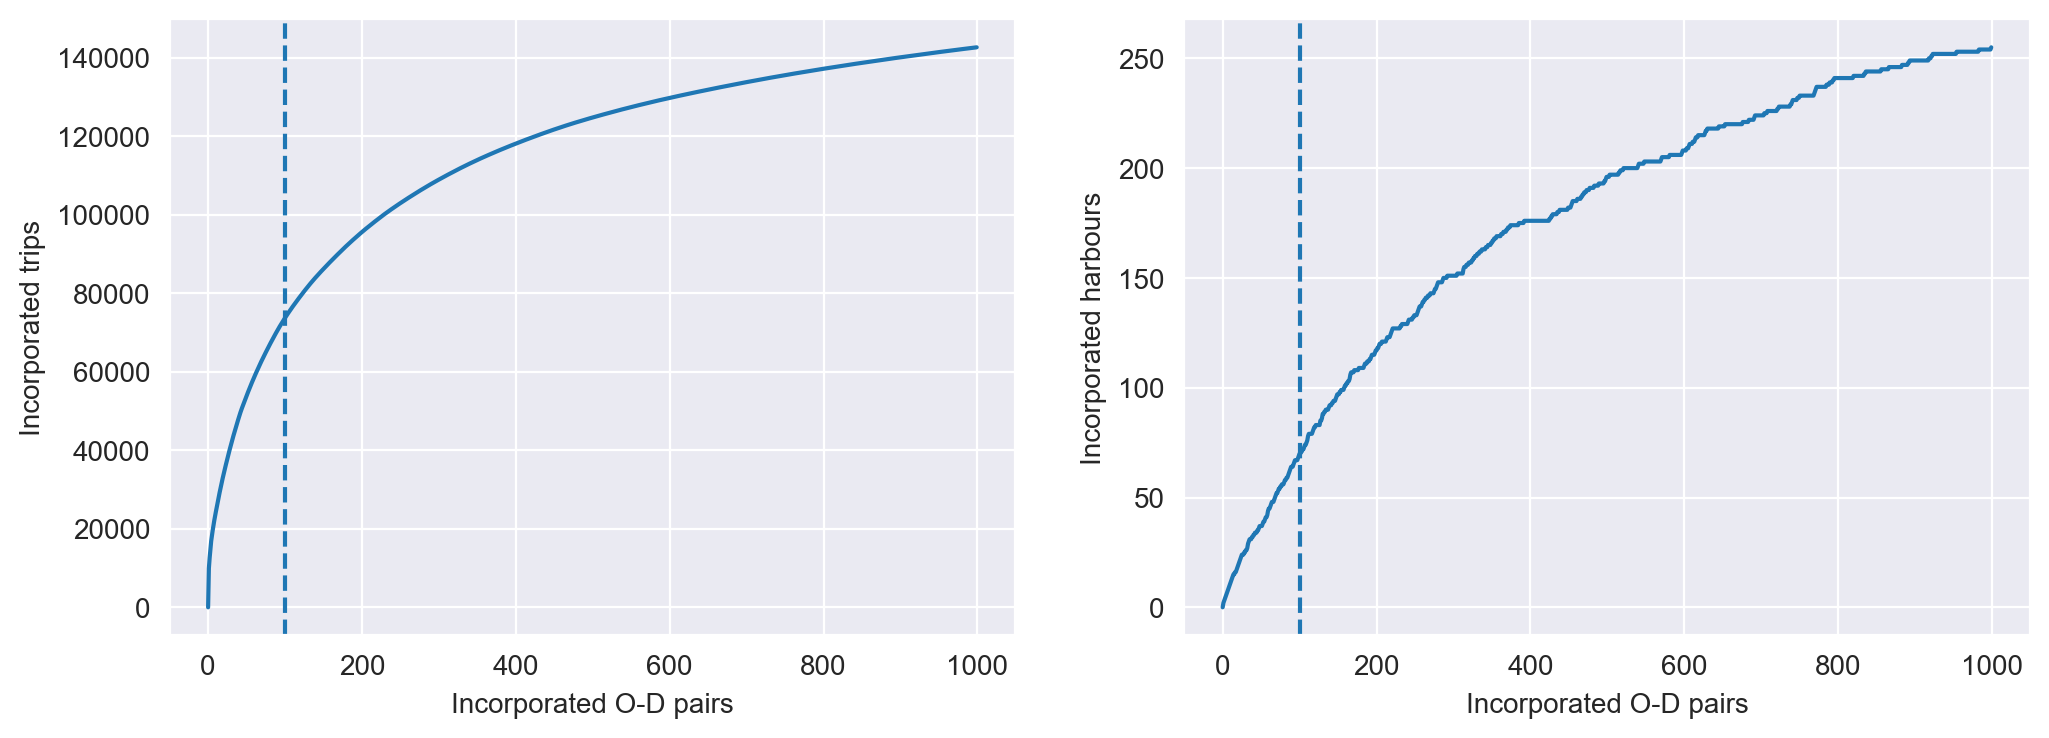

In [36]:
# setup grid
fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,4))

# plot cumulative trips on the left
sns.lineplot(x='i',y='cumulative_trips', data=df_main_c.head(1000), ax=ax[0])
ax[0].axvline(x=100, linestyle="--")
ax[0].set_ylabel('Incorporated trips')
ax[0].set_xlabel('Incorporated O-D pairs')

# plot captured routes on the left
sns.lineplot(x=a, y=b, ax=ax[1])
ax[1].axvline(x=100, linestyle="--")
ax[1].set_ylabel('Incorporated harbours')
ax[1].set_xlabel('Incorporated O-D pairs')
# draw
plt.show()

### Also create data frame below for all O-D pairs
Not hourly to save time, only to be able to calculate missed vs captured flow

In [37]:
# ordes = []
# df_main.reset_index(drop=True, inplace=True)
# for i in range(len(df_main)):
#     ordes.append((df_main['origin'][i], df_main['destination'][i]))
#
# trip_dict_subset = {i:trip_dict_main[i] for i in trip_dict_main.keys() if (i[0],i[1]) in ordes}

In [38]:
# # make dataframe dict wih a key for each column
# trip_dict_df_main = {'origin': [], 'destination': [], 'hour':[]}
# for i in df_2021.SK_CODE.unique():
#     trip_dict_df_main[i] = []
#
# # now fill this dict
# for key in ordes:
#     # append values from dict a
#     for hour in list(np.arange(0,24,1)):
#         trip_dict_df_main['origin'].append(key[0])
#         trip_dict_df_main['destination'].append(key[1])
#         trip_dict_df_main['hour'].append(hour)
#         #now append values from other dict, for each ship types
#         for ship_type in df_2021.SK_CODE.unique():
#             #if ships have travelled from A to B, append this value
#             if (key[0], key[1], ship_type, hour) in trip_dict_main.keys():
#                 trip_dict_df_main[ship_type].append(trip_dict_main[(key[0], key[1], ship_type, hour)])
#             elif (key[1], key[0], ship_type, hour) in trip_dict_main.keys():
#                 trip_dict_df_main[ship_type].append(trip_dict_main[(key[1], key[0], ship_type, hour)])
#             else:
#                 # no? Then no ships of this type have travelled this path, append 0
#                 trip_dict_df_main[ship_type].append(0)
# df_main_hourly = pd.DataFrame.from_dict(trip_dict_df_main)
# df_main_hourly

In [39]:
# df_main_hourly.insert(2, 'trip_count', df_main_hourly.iloc[:, 3:].sum(axis=1))

In [40]:
# df_main_hourly_full = df_main_hourly.groupby(['origin', 'destination']).sum().reset_index().sort_values('trip_count',ascending=False)

In [41]:
# pickle.dump(df_main_hourly_full, open('data/df_main_hourly_full2.p', 'wb'))
df_main_hourly_full = pickle.load(open('data/df_main_hourly_full2.p', 'rb'))

In [42]:
df_main_hourly_full

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
7164,NLRTM,NLAMS,9932,276,2076,3510,0,427,102,1316,...,19,5,5,7,39,4,0,0,0,0
7251,NLRTM,NLMOE,2685,276,70,1584,0,56,2,144,...,0,2,0,0,1,0,0,0,0,0
7284,NLRTM,NLVLI,2151,276,190,658,0,140,10,414,...,0,0,1,2,0,0,0,1,0,0
370,NLAMS,NLAER,2114,276,6,132,0,7,2,0,...,3,0,37,1,0,3,0,1,1,0
8611,NLVEG,NLRTM,1467,276,0,1,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,NLOSS,NLDHR,1,276,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2512,NLFAR,NLWSD,1,276,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6487,NLOSS,NLCPI,1,276,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6485,NLOSS,NLBOX,1,276,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
ship_data = pd.read_excel('data/ship_types.xlsx')
ship_data.fillna(0, inplace=True)
ship_data = dict(zip(ship_data['RWS-class'], ship_data['Factor']))

In [44]:
df_main_hourly_full['key'] = df_main_hourly_full['origin']+df_main_hourly_full['destination']

In [46]:
# df_main_hourly_full.insert(0, 'key', df_main_hourly_full['origin']+df_main_hourly_full['destination'])

In [47]:
def calculate_flow(row):
    # loop over data frame
    # subset all data ship type data
    flow_value = 0
    for i in ship_data.keys():
        flow_value += row.loc[i] * ship_data[i]
    return flow_value/365

In [48]:
df_main_hourly_full['total_flow'] = df_main_hourly_full.apply(lambda x: calculate_flow(x), axis=1)

In [49]:
df_main_hourly_full.reset_index(drop=True, inplace=True)

In [50]:
df_full_flow = df_main_hourly_full.sort_values('total_flow', ascending=False)

In [51]:
df_main_c = df_main.copy()
df_main_c = df_main_c.reset_index()
df_main_c = df_main_c.rename(columns={'index': 'i'})
df_main_c['cumulative_trips'] = df_main_c.apply((lambda x: (df_main.iloc[:x.i, 2].sum())), axis=1)

### How many unique harbours are in the top 100/200?

In [52]:
len(set(list(df_full_flow.head(200).origin.unique()) + list(df_full_flow.head(200).destination.unique())))

100

## Only include top 100

In [53]:
# now only keep entries of trip_dict_main that are part of top 100 OD pairs
top100 = df_main.head(100)
top100.reset_index(drop=True, inplace=True)
ordes = []
for i in range(len(top100)):
    ordes.append((top100['origin'][i], top100['destination'][i]))

trip_dict_subset = {i:trip_dict_main[i] for i in trip_dict_main.keys() if (i[0],i[1]) in ordes}

In [54]:
print("remaining:", top100.trip_count.sum(), "dropped", df_main.trip_count.sum()-top100.trip_count.sum())

remaining: 73742 dropped 101609


In [55]:
# make dataframe dict wih a key for each column
trip_dict_df_main = {'origin': [], 'destination': [], 'hour':[]}
for i in df_2021.SK_CODE.unique():
    trip_dict_df_main[i] = []

# now fill this dict
for key in ordes:
    # append values from dict a
    for hour in list(np.arange(0,24,1)):
        trip_dict_df_main['origin'].append(key[0])
        trip_dict_df_main['destination'].append(key[1])
        trip_dict_df_main['hour'].append(hour)
        #now append values from other dict, for each ship types
        for ship_type in df_2021.SK_CODE.unique():
            #if ships have travelled from A to B, append this value
            if (key[0], key[1], ship_type, hour) in trip_dict_main.keys():
                trip_dict_df_main[ship_type].append(trip_dict_main[(key[0], key[1], ship_type, hour)])
            elif (key[1], key[0], ship_type, hour) in trip_dict_main.keys():
                trip_dict_df_main[ship_type].append(trip_dict_main[(key[1], key[0], ship_type, hour)])
            else:
                # no? Then no ships of this type have travelled this path, append 0
                trip_dict_df_main[ship_type].append(0)
df_main_hourly = pd.DataFrame.from_dict(trip_dict_df_main)
df_main_hourly

,origin,destination,hour,M12,M8,BII-6b,M10,BIIa-1,M9,BII-6l,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,0,91,109,0,18,2,45,0,...,0,0,0,0,1,0,0,0,0,0
1,NLRTM,NLAMS,1,78,110,0,17,3,55,0,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,2,52,122,0,10,3,46,0,...,0,1,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,3,52,117,0,9,4,52,0,...,0,1,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,4,55,144,0,14,1,72,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,NLAMS,NLZWI,19,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2396,NLAMS,NLZWI,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,NLAMS,NLZWI,21,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2398,NLAMS,NLZWI,22,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_main_hourly.insert(2, 'trip_count', df_main_hourly.iloc[:, 3:].sum(axis=1))

In [57]:
df_main_hourly

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,323,0,91,109,0,18,2,45,...,0,0,0,0,1,0,0,0,0,0
1,NLRTM,NLAMS,302,1,78,110,0,17,3,55,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,275,2,52,122,0,10,3,46,...,0,1,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,303,3,52,117,0,9,4,52,...,0,1,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,367,4,55,144,0,14,1,72,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,NLAMS,NLZWI,17,19,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2396,NLAMS,NLZWI,12,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,NLAMS,NLZWI,13,21,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2398,NLAMS,NLZWI,7,22,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pickle.dump( df_main_hourly, open( "ABM/own_work/data/df_trips_per_path_hourly.p", "wb" ) )

In [59]:
df_main_hourly.groupby(['origin', 'destination']).sum().reset_index().sort_values('trip_count').reset_index()

,index,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,...,B03,C4,B04,C2l,BII-2L,B02,C1b,C2b,B01,C1l
0,17,NLAMS,NLZWI,309,276,0,46,0,3,1,...,0,0,1,0,0,0,0,0,0,0
1,74,NLRTM,NLSLU,310,276,3,205,0,46,0,...,0,0,0,1,0,0,0,0,0,0
2,69,NLRTM,NLLID,311,276,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45,NLKGZ,NLZAA,316,276,0,0,0,0,211,...,1,0,5,0,0,0,0,0,0,0
4,38,NLHTB,NLBON,324,276,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93,NLVEG,NLRTM,1467,276,0,1,0,0,0,...,11,0,0,0,0,0,0,0,0,0
96,7,NLAMS,NLAER,2114,276,6,132,0,7,2,...,3,0,37,1,0,3,0,1,1,0
97,77,NLRTM,NLVLI,2151,276,190,658,0,140,10,...,0,0,1,2,0,0,0,1,0,0
98,71,NLRTM,NLMOE,2685,276,70,1584,0,56,2,...,0,2,0,0,1,0,0,0,0,0


## Now translate into fuel consumption value for each path
Idea: take 1 vessel as a basis, and assume that fuel consumption is linearly correlated with average engine power, to be able to use index
Capacity is likely x vessels per day of a certain type for a charging unit, depending on the charging time.
Hence, computing the average amount of that type of vehicles that comes by everyday makes sense.

### First determine factors

In [60]:
ship_data = pd.read_csv('data/Vessel-database-2.csv')
ship_data.avv_class = ship_data.avv_class.str.replace("_","-")
ship_data.avv_class = ship_data.avv_class.str.replace("BII-2l","BII-2L")
ship_data.fillna(0, inplace=True)
# only keep relevant columns
ship_data = ship_data.loc[:, ["P_installed", "speed_loaded", "speed_unloaded", "avv_class", "cemt_class"]]
ship_data = ship_data.rename(columns={'P_installed':'P_average'})
ship_data.rename(columns={'avv_class':'RWS-class'}, inplace=True)

In [61]:
ship_data

,P_average,speed_loaded,speed_unloaded,RWS-class,cemt_class
0,175.0,3.0830,4.4700,M1,I
1,250.0,3.3610,4.6380,M2,II
2,435.0,3.8610,4.6380,M3,III
3,435.0,4.0000,4.8890,M4,III
4,435.0,3.9160,5.0270,M5,III
5,690.0,3.9160,5.1940,M6,IV
6,690.0,3.7780,5.3610,M7,IV
7,1356.0,3.7777,5.3333,M8,Va
8,1744.0,3.8050,5.4160,M9,Va
9,1649.0,3.5830,5.3880,M10,VIa


### Do we have a factor for each column?

In [62]:
# import final flow df
top100 = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", 'rb'))

In [63]:
test = top100.iloc[:, 4:-1]

In [64]:
# Check for which columns we do not have a factor
set(top100.columns[4:-1]) - set(ship_data['RWS-class'])

{'BIIL-1', 'BIIa-1', 'M0'}

In [65]:
# no columns in df without factor!
set(ship_data['RWS-class']) - set(top100.columns[4:-1])

set()

- Missing values for BIIL-1 and BIIa-1 can be taken from the other data set.
- Speed is assumed to be equal to other Va class barge ship which is present in vessel dataset 1
- M0 will be neglected, as these are the smallest ships, which have quite a largely varying transport and engine capacity.

In [66]:
ship_data_2 = pd.read_excel('data/DTV_shiptypes_database.xlsx')

In [67]:
ship_data_2 = ship_data_2.loc[ship_data_2['RWS-class'].isin(['BIIL-1', 'BIIa-1'])]
ship_data_2 = ship_data_2.loc[:, ['RWS-class', 'CEMT-class', 'Engine power averge [kW]']]
ship_data_2['speed_loaded'] = ship_data.loc[ship_data['RWS-class'] == 'BII-1'].speed_loaded.values[0]
ship_data_2['speed_unloaded'] = ship_data.loc[ship_data['RWS-class'] == 'BII-1'].speed_unloaded.values[0]
ship_data_2 = ship_data_2.rename(columns={'CEMT-class':'cemt_class', 'Engine power averge [kW]':'P_average'})

In [68]:
ship_data_2

,RWS-class,cemt_class,P_average,speed_loaded,speed_unloaded
26,BIIa-1,Va,1425.0,3.555,4.778
27,BIIL-1,Va,1425.0,3.555,4.778


In [69]:
ship_data = pd.concat([ship_data, ship_data_2], ignore_index=True)

In [70]:
ship_data['battery_size'] = ship_data.apply(lambda x: (60000/(x.speed_loaded*3.6*1000))*x.P_average, axis=1)

In [71]:
ship_data['Factor'] = ship_data.battery_size.apply(lambda n: (n/ship_data.P_average[0]))

In [72]:
ship_data_factors = dict(zip(ship_data['RWS-class'],ship_data['battery_size']))

In [73]:
ship_data_factors['M0'] = 0

In [74]:
pickle.dump(ship_data_factors, open('data/flow_comp_factors_unscaled.p', 'wb'))
pickle.dump(ship_data, open('data/full_ship_data.p', 'wb'))
ship_data.to_excel("data/ship_types.xlsx")

### Now use factors for flow computation per route

In [75]:
from flow_computation import flow_computation

In [76]:
flows = flow_computation(top100)

In [77]:
flows

{('NLABL', 'NLRTM', 0): 56.29195738171413,
 ('NLAER', 'NLLEY', 0): 18.64663879143117,
 ('NLAER', 'NLNIE', 0): 32.70412910827895,
 ('NLAER', 'NLRTM', 0): 72.11443082292415,
 ('NLAER', 'NLSWI', 0): 12.01451448521234,
 ('NLALK', 'NLIJM', 0): 15.80845333786233,
 ('NLALM', 'NLAMS', 0): 16.708562131082612,
 ('NLAMS', 'NLAER', 0): 94.49126335167097,
 ('NLAMS', 'NLDEV', 0): 28.057627922201387,
 ('NLAMS', 'NLHEJ', 0): 13.299903912364744,
 ('NLAMS', 'NLMOE', 0): 0.11583048188257906,
 ('NLAMS', 'NLMOE', 1): 1.874308737066138,
 ('NLAMS', 'NLMOE', 2): 8.1303236795302,
 ('NLAMS', 'NLMOE', 3): 59.23330450535341,
 ('NLAMS', 'NLMOE', 4): 7.405522911232725,
 ('NLAMS', 'NLOSS', 0): 23.292907276321873,
 ('NLAMS', 'NLTIE', 0): 19.854896401728404,
 ('NLAMS', 'NLUTC', 0): 0.0,
 ('NLAMS', 'NLUTC', 1): 28.978237131297526,
 ('NLAMS', 'NLWGW', 0): 19.03978516148663,
 ('NLAMS', 'NLWMO', 0): 10.980106481381483,
 ('NLAMS', 'NLZAA', 0): 13.204962301148953,
 ('NLAMS', 'NLZWI', 0): 0.4269844051709364,
 ('NLAMS', 'NLZW

In [78]:
#sort flows from large to small
flows = dict(sorted(flows.items(), key=lambda item: item[1], reverse=True))

In [79]:
flows

{('NLRTM', 'NLAMS', 1): 541.6677238381009,
 ('NLRTM', 'NLAMS', 2): 487.3470751907379,
 ('NLRTM', 'NLVLI', 0): 209.59560795036018,
 ('NLRTM', 'NLMOE', 0): 182.87848668331736,
 ('NLHAR', 'NLWTE', 0): 104.10244250824906,
 ('NLAMS', 'NLAER', 0): 94.49126335167097,
 ('NLRTM', 'NLKAM', 2): 91.61534736773064,
 ('NLVLI', 'NLAMS', 1): 86.39060733920132,
 ('NLUTC', 'NLRTM', 0): 86.29136735716855,
 ('NLGOR', 'NLRTM', 0): 77.02871288925206,
 ('NLTLB', 'NLRTM', 1): 76.58298900510103,
 ('NLRTM', 'NLMOE', 1): 76.49392921174577,
 ('NLHGL', 'NLRTM', 0): 76.13778743562912,
 ('NLRTM', 'NLNIJ', 0): 72.62279850692559,
 ('NLNIJ', 'NLWAS', 0): 72.34823199752678,
 ('NLAER', 'NLRTM', 0): 72.11443082292415,
 ('NLRTM', 'NLOOS', 1): 71.91169959641574,
 ('NLRTM', 'NLTNZ', 0): 70.34783968766133,
 ('NLTNZ', 'NLVLI', 0): 69.65977200055913,
 ('NLNIJ', 'NLABL', 0): 67.1383432211326,
 ('NLOOS', 'NLTLB', 0): 65.84010033159483,
 ('NLVEG', 'NLRTM', 0): 65.04000389117675,
 ('NLZWO', 'NLAMS', 0): 62.58445906536771,
 ('NLDOR'

## Get and clean harbour data NL, Ger and Bel

In [80]:
# now get coordinates harbours, in three files, check encoding frist below
pd.read_csv('data/harbour_codes_coords/2021-2 UNLOCODE CodeListPart1.csv', encoding="ISO-8859-1", header=None, sep=",",
            index_col=None)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,AD,NaN,.ANDORRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,AD,ALV,Andorra la Vella,Andorra la Vella,NaN,--34-6--,AI,601.0,NaN,4230N 00131E,NaN
2,NaN,AD,CAN,Canillo,Canillo,NaN,--3-----,RL,307.0,NaN,4234N 00135E,NaN
3,NaN,AD,ENC,Encamp,Encamp,NaN,--3-----,RL,307.0,NaN,4232N 00134E,NaN
4,NaN,AD,ESC,Escaldes-Engordany,Escaldes-Engordany,NaN,--3-----,RL,307.0,NaN,4231N 00133E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
54611,NaN,FR,ZTG,Zetting,Zetting,57,--3-----,RL,1901.0,NaN,4905N 00708E,NaN
54612,NaN,FR,ZL2,Zilia,Zilia,2B,-----6--,RL,1901.0,NaN,4231N 00854E,NaN
54613,NaN,FR,ZWL,Zinswiller,Zinswiller,67,--3-----,RL,1901.0,NaN,4855N 00735E,NaN
54614,NaN,FR,PCZ,Zoteux,Zoteux,62,-----6--,RL,1001.0,NaN,5037N 00153E,NaN


In [81]:
# now identify all files to combine
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk('data/harbour_codes_coords'):
    f.extend(filenames)
    break

In [82]:

#empty list to store data
li = []

#read everything in as object for now
for filename in f:
    df = pd.read_csv("data/harbour_codes_coords/" + str(filename), sep=',', index_col=None, header=None,
                     encoding="ISO-8859-1")
    print(filename, 'handled')
    li.append(df)

2021-2 UNLOCODE CodeListPart1.csv handled
2021-2 UNLOCODE CodeListPart2.csv handled
2021-2 UNLOCODE CodeListPart3.csv handled


In [83]:
#create df
df_harbour_codes = pd.concat(li, axis=0, ignore_index=True)
df_benelux=df_harbour_codes.copy()
#subset Dutch harbours
# df_benelux = df_harbour_codes.loc[(df_harbour_codes[1] == 'NL')]

# uncomment below to loc benelux, for now only use NL because of scope
# df_benelux = df_harbour_codes.loc[
#     (df_harbour_codes[1] == 'NL') | (df_harbour_codes[1] == 'DE') | (df_harbour_codes[1] == 'BE') | (
#                 df_harbour_codes[1] == 'LU')]

In [84]:
#fillna
df_benelux.fillna(np.nan, inplace=True)

In [85]:
# give appropriate column names
df_benelux.rename(columns={0: 'mutation', 1: 'country', 2: 'city_abbr', 3: 'city_full', 4: 'city_full_2', 5: 'subdivision', 6: 'function', 7:'status', 8:'date', 9:'iata_code', 10: 'coords', 11: 'comments'}, inplace=True)

In [86]:
df_benelux

,mutation,country,city_abbr,city_full,city_full_2,subdivision,function,status,date,iata_code,coords,comments
0,NaN,AD,NaN,.ANDORRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,AD,ALV,Andorra la Vella,Andorra la Vella,NaN,--34-6--,AI,601.0,NaN,4230N 00131E,NaN
2,NaN,AD,CAN,Canillo,Canillo,NaN,--3-----,RL,307.0,NaN,4234N 00135E,NaN
3,NaN,AD,ENC,Encamp,Encamp,NaN,--3-----,RL,307.0,NaN,4232N 00134E,NaN
4,NaN,AD,ESC,Escaldes-Engordany,Escaldes-Engordany,NaN,--3-----,RL,307.0,NaN,4231N 00133E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
115984,NaN,ZW,STH,Southerton,Southerton,NaN,--3-----,RL,201.0,NaN,1751S 03101E,NaN
115985,NaN,ZW,THJ,Thompson Junction,Thompson Junction,NaN,-23-----,RL,701.0,NaN,1800S 02626E,NaN
115986,NaN,ZW,VFA,Victoria Falls,Victoria Falls,NaN,---4----,AI,9501.0,NaN,NaN,NaN
115987,NaN,ZW,ZMZ,Zimbabwe,Zimbabwe,MV,1-3-----,RL,1401.0,NaN,2016S 03055E,NaN


In [87]:
# subset relevant columns
# df_benelux = df_benelux.loc[:,['country','city_abbr','function', 'coords']]

In [88]:
#reset index
df_benelux.reset_index(inplace=True,drop=True)

In [89]:
# drop rows with nan values for necessary columns
# df_benelux.dropna(subset=['country', 'city_abbr', 'coords'], inplace = True)

In [90]:
# # convert columns to be normal strings
# for i in df_benelux.columns:
#     df_benelux[i] = df_benelux[i].astype('|S80')
#     df_benelux[i] = df_benelux[i].apply(lambda x: x.decode('utf-8'))

In [91]:
df_benelux.replace('nan', np.nan)

,mutation,country,city_abbr,city_full,city_full_2,subdivision,function,status,date,iata_code,coords,comments
0,NaN,AD,NaN,.ANDORRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,AD,ALV,Andorra la Vella,Andorra la Vella,NaN,--34-6--,AI,601.0,NaN,4230N 00131E,NaN
2,NaN,AD,CAN,Canillo,Canillo,NaN,--3-----,RL,307.0,NaN,4234N 00135E,NaN
3,NaN,AD,ENC,Encamp,Encamp,NaN,--3-----,RL,307.0,NaN,4232N 00134E,NaN
4,NaN,AD,ESC,Escaldes-Engordany,Escaldes-Engordany,NaN,--3-----,RL,307.0,NaN,4231N 00133E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
115984,NaN,ZW,STH,Southerton,Southerton,NaN,--3-----,RL,201.0,NaN,1751S 03101E,NaN
115985,NaN,ZW,THJ,Thompson Junction,Thompson Junction,NaN,-23-----,RL,701.0,NaN,1800S 02626E,NaN
115986,NaN,ZW,VFA,Victoria Falls,Victoria Falls,NaN,---4----,AI,9501.0,NaN,NaN,NaN
115987,NaN,ZW,ZMZ,Zimbabwe,Zimbabwe,MV,1-3-----,RL,1401.0,NaN,2016S 03055E,NaN


In [92]:
df_benelux['harbour_code'] = df_benelux.country+df_benelux.city_abbr

In [93]:
df_benelux = df_benelux.loc[:,['country','city_abbr','city_full','function','coords','harbour_code']]

In [94]:
# save cleaned data
df_benelux.to_csv('data/cleaned_harbours.csv')

In [95]:
import pandas as pd
pd.read_excel('data/ship_types.xlsx')

,Unnamed: 0,P_average,speed_loaded,speed_unloaded,RWS-class,cemt_class,battery_size,Factor
0,0,175,3.0830,4.4700,M1,I,946.048221,5.405990
1,1,250,3.3610,4.6380,M2,II,1239.710404,7.084059
2,2,435,3.8610,4.6380,M3,III,1877.751878,10.730011
3,3,435,4.0000,4.8890,M4,III,1812.500000,10.357143
4,4,435,3.9160,5.0270,M5,III,1851.378958,10.579308
5,5,690,3.9160,5.1940,M6,IV,2936.670072,16.780972
6,6,690,3.7780,5.3610,M7,IV,3043.938592,17.393935
7,7,1356,3.7777,5.3333,M8,Va,5982.476110,34.185578
8,8,1744,3.8050,5.4160,M9,Va,7639.071397,43.651837
9,9,1649,3.5830,5.3880,M10,VIa,7670.480975,43.831320
